# Class occurrences for all experiments

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pickle5 as pickle
#sys.path.append('/work/bb1018/b380873/nawdex-hackathon/shared/')
sys.path.append('/groups/sylvia/nawdex-hackathon/shared/')
from dict_nawdexsims import *

farbe = colordictionary()
sims = simdictionary()
ana = anadaysdictionary()

In [4]:
print( pickle.__version__ )

NameError: name 'pickle5' is not defined

In [37]:
# Number of cloud classes defined.
nclasses = 8

# Directories
griddir = '/groups/sylvia/nawdex-hackathon/bb1018/icon_r_hackathon/grids/'
georgedir = '/pf/b/b380796/scratch/hackathon/george/'
maskdir = '/groups/sylvia/nawdex-hackathon/domain-mean_data/openoceanmask/'
resolutions = ['80km','40km','20km','10km','5km','2km','2-shcon']
class_names = ['HI','MED','LO','H-M','M-L','H-L','H-M-L','Clear-sky']

In [33]:
for res in resolutions:
    print(res)
    if res == '80km' or res == '40km' or res == '20km':
        exp_list = ['0001','0002','0003','0004','0005','0006','0007','0008','0009','0010']
    elif res == '2-shcon':
        exp_list = ['0001-shcon','0002-shcon','0005-shcon','0006-shcon',
                    '0007-shcon','0008-shcon','0009-shcon','0010-shcon','0011-shcon','0012-shcon']
    elif res == '10km' or res == '5 km':
        exp_list = ['0001','0002','0003','0004','0005','0006','0007','0008','0009','0010','0011','0012']
    else:
        exp_list = ['0001','0002','0005','0006','0007','0008','0009','0010','0011','0012']
    
    # We need a separate "resolution string" for the 2-km simulation, shallow convection off.
    if res == '2-shcon':
        res = '2km'
    
    for exp in exp_list:
        #print('   ' + exp)
        Aarea_df = pd.DataFrame(columns=['Cloud class','Resolution','Occurrence_thr1','Occurrence_thr2',
                                 'Occurrence_thr3'])
        
        # Read in George's classifications for three different percentiles.
        fi_thres1 = xr.open_dataset(georgedir + 'nawdexnwp_' + res + '_cloudclass_mis_' + exp + '.nc')
        fi_thres2 = xr.open_dataset(georgedir + 'nawdexnwp_' + res + '_cloudclass_mis_' + exp + '_hq60_mq60_lq25.nc')
        fi_thres3 = xr.open_dataset(georgedir + 'nawdexnwp_' + res + '_cloudclass_mis_' + exp + '_hq65_mq70_lq35.nc')
  
        A1 = fi_thres1['clch']
        A2 = fi_thres2['clch'] 
        A3 = fi_thres3['clch'] 
    
        # Read in the grid and mask for area-weighting. Their dimensions must agree below.
        if res == '2km':
            grid = xr.open_dataset(griddir + 'icon-grid_nawdex_78w40e23n80n_R2500m.nc')
        else:
            grid = xr.open_dataset(griddir + 'icon-grid_nawdex_78w40e23n80n_R' + res[:-2] + '000m.nc')
            
        mask = xr.open_dataset(maskdir + 'nawdexnwp-' + res + '-mis-' + exp + '_openoceanmask.nc')['mask_openocean']
        mask = mask.rename({'ncells':'cell'})
        ncells = A1.sizes['ncells']
        timesteps = A1.sizes['time']
        cellarea = grid['cell_area'].where(mask == 1)
        totarea = cellarea.where(mask == 1).sum('cell').values
    
        # Now throw out the NaN values as the cloud classifications have done.
        cellarea = cellarea.values; cellarea = cellarea[~np.isnan(cellarea)]
    
        # Iterate over the timesteps to set Cloud class, resolution, occurrence, and radiative values.
        for dt in np.arange(timesteps):
            B1 = A1[{'time':dt}]
            B2 = A2[{'time':dt}]
            B3 = A3[{'time':dt}]
        
            for cloud_class in np.arange(nclasses):         
                occ1 = np.nansum(cellarea[B1 == cloud_class+1])/totarea*100.
                occ2 = np.nansum(cellarea[B2 == cloud_class+1])/totarea*100.
                occ3 = np.nansum(cellarea[B3 == cloud_class+1])/totarea*100.
                Aarea_df = Aarea_df.append({'Cloud class' : class_names[cloud_class],'Resolution' : res, 'Occurrence_thr1' : occ1,
                                       'Occurrence_thr2' : occ2, 'Occurrence_thr3' : occ3}, ignore_index=True)
                                    
        Aarea_df.to_pickle('cloud_class_occurrence_area_weighting_' + res + '-mis-' + exp + '.pkl')

80km


### On Puma starting from here

In [7]:
basedir = '/groups/sylvia/nawdex-hackathon/occurrence_data/'

# Merge all resolutions for mp1 experiments.
res_exp_pair_mp1 = [('80km','0001'), ('80km','0003'), ('80km','0005'), ('80km','0007'), ('80km','0009'),
                    ('40km','0001'), ('40km','0003'), ('40km','0005'), ('40km','0007'), ('40km','0009'),
                    ('20km','0001'), ('20km','0003'), ('20km','0005'), ('20km','0007'), ('20km','0009'),
                    ('10km','0001'), ('10km','0005'), ('10km','0007'), ('10km','0009'), ('10km','0011'),
                    ('5km','0001'), ('5km','0005'), ('5km','0007'), ('5km','0009'), ('5km','0011'),
                    ('2km','0001-shcon'),('2km','0005-shcon'),('2km','0007-shcon'),('2km','0009-shcon'),
                    ('2km','0011-shcon')]
        
# Merge all resolutions for mp2 experiments.
res_exp_pair_mp2 = [('80km','0002'), ('80km','0004'), ('80km','0006'), ('80km','0008'), ('80km','0010'),
                    ('40km','0002'), ('40km','0004'), ('40km','0006'), ('40km','0008'), ('40km','0010'),
                    ('20km','0002'), ('20km','0004'), ('20km','0006'), ('20km','0008'), ('20km','0010'),
                    ('10km','0002'), ('10km','0006'), ('10km','0008'), ('10km','0010'), ('10km','0012'),
                    ('5km','0002'), ('5km','0006'), ('5km','0008'), ('5km','0010'), ('5km','0012'),
                    ('2km','0002-shcon'),('2km','0006-shcon'),('2km','0008-shcon'),('2km','0010-shcon'),
                    ('2km','0012-shcon')]

# Generate a new Pandas dataframe
mp1_df = pd.DataFrame()
mp2_df = pd.DataFrame()

# Compile all 1-moment microphysics simulation into one dataframe.
with open(basedir + 'cloud_class_occurrence_area_weighting_80km-mis-0001.pkl', 'rb') as fh:
    init = pickle.load(fh)
#init = pd.read_pickle(basedir + 'cloud_class_occurrence_area_weighting_80km-mis-0001.pkl')

for i, pair in enumerate(res_exp_pair_mp1[1:]):
    with open(basedir + 'cloud_class_occurrence_area_weighting_' + pair[0] + '-mis-' + pair[1] + '.pkl', 'rb') as fh:
        temp = pickle.load(fh)
    #temp = pd.read_pickle(basedir + 'cloud_class_occurrence_area_weighting_' + pair[0] + '-mis-' + pair[1] + '.pkl')
    if i == 0:
        mp1_df = pd.concat([init, temp])     
    else:
        mp1_df = pd.concat([mp1_df, temp])

# Compile all 2-moment microphysics simulation into one dataframe.
with open(basedir + 'cloud_class_occurrence_area_weighting_80km-mis-0002.pkl', 'rb') as fh:
    init = pickle.load(fh)
#init = pd.read_pickle(basedir + 'cloud_class_occurrence_area_weighting_80km-mis-0002.pkl')
for i, pair in enumerate(res_exp_pair_mp2[1:]):
    with open(basedir + 'cloud_class_occurrence_area_weighting_' + pair[0] + '-mis-' + pair[1] + '.pkl', 'rb') as fh:
        temp = pickle.load(fh)
    #temp = pd.read_pickle(basedir + 'cloud_class_occurrence_area_weighting_' + pair[0] + '-mis-' + pair[1] + '.pkl')
    if i == 0:
        mp2_df = pd.concat([init, temp])     
    else:
        mp2_df = pd.concat([mp2_df, temp]) 

In [13]:
bd = '/groups/sylvia/nawdex-hackathon/occurrence_data/'
mp2_df.to_pickle( bd + 'cloud_class_occurrence_area_weighting_mp2.pkl' )
mp1_df.to_pickle( bd + 'cloud_class_occurrence_area_weighting_mp1.pkl' )

In [64]:
mp1_df[(mp1_df['Resolution'] == '2km')]

,Cloud class,Resolution,Occurrence_thr1,Occurrence_thr2,Occurrence_thr3
0,HI,2km,7.322039,0.000000,7.828716
1,MED,2km,1.984772,0.000000,2.123617
2,LO,2km,33.255041,30.685053,31.694923
3,H-M,2km,3.804920,0.000000,3.995187
4,M-L,2km,10.974058,14.032779,10.009972
...,...,...,...,...,...
1155,H-M,2km,4.810290,0.000000,4.802252
1156,M-L,2km,14.386731,17.551827,13.442370
1157,H-L,2km,8.733861,7.766224,8.020397
1158,H-M-L,2km,16.457467,18.914603,14.540825


[None, None]

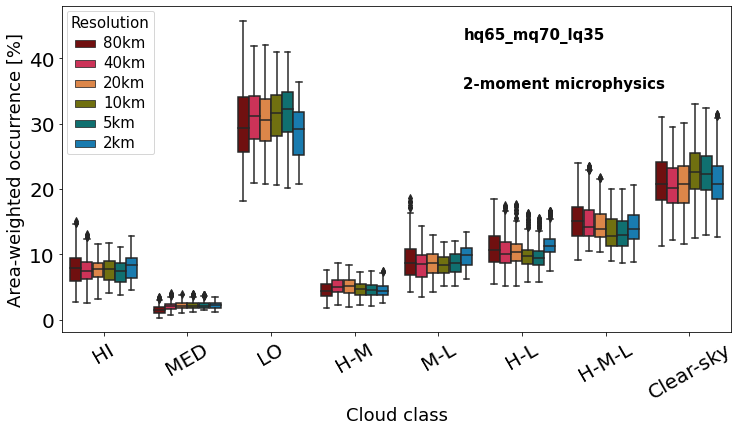

In [12]:
resolutions = ['80km','40km','20km','10km','5km','2km']

fs = 15
thres = 3 # Which threshold do you want to look at? 1-3
mp = 2 # Which microphysics scheme do you want to look at? 1-2

thres_str = ['hq60_mq60_lq25', 'hq62_mq67_lq30', 'hq65_mq70_lq35']
if mp == 1:
    A = mp1_df
else:
    A = mp2_df

# Plot the spatiotemporal probability distribution of the different classes for a threshold of 10% AND area-weighting.
fig1 = plt.figure(figsize=(12,6))
ax = sns.boxplot(x='Cloud class', y='Occurrence_thr' + str(thres), hue='Resolution', data=A,
                 hue_order=resolutions, palette=farbe)
ax.text(0.6,0.9,thres_str[thres-1],fontsize=fs,weight='bold',transform=ax.transAxes)
ax.text(0.6,0.75,str(mp)+'-moment microphysics',fontsize=fs,weight='bold',transform=ax.transAxes)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=fs+5)
ax.tick_params(axis="y", labelsize=fs+5)
ax.set_ylabel('Area-weighted occurrence [%]',fontsize=fs+3)
ax.set_xlabel('Cloud class',fontsize=fs+3)
plt.setp(ax.get_legend().get_texts(), fontsize=fs)
plt.setp(ax.get_legend().get_title(), fontsize=fs)
#plt.savefig('cloud_class_occurrence_area_weighting_' + thres_str[thres-1] + '_mp' + str(mp) + '.pdf')

In [68]:
symbol = {'thr1' : 'o', 'thr2' : 's', 'thr3' : '*'}
class_names = ['HI','MED','LO','H-M','M-L','H-L','H-M-L','Clear-sky']

# Store the mean occurrence for 3 thresholds, 6 resolutions, and 8 classes.
mean_occ = np.zeros((3,6,8))

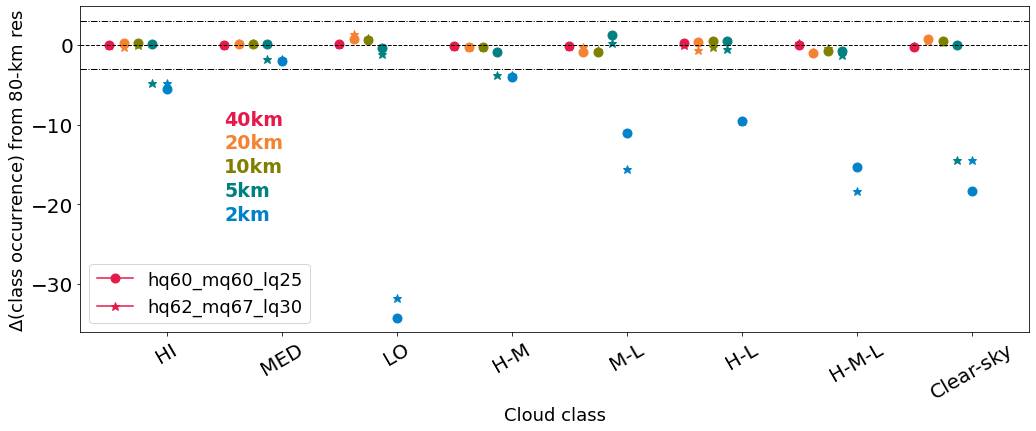

In [86]:
mp = 1 # Which microphysics scheme do you want to look at? 1-2

if mp == 1:
    A = mp1_df
else:
    A = mp2_df

# Calculate the mean occurrence for a given class, resolution, and threshold.
for c_indx, c in enumerate(class_names):
    for r_indx, r in enumerate(resolutions[1:]):
        for t_indx, t in enumerate(['thr1','thr2','thr3']):
            #print(A[(A['Cloud class'] == cloud_class)])  #(A['Resolution'] == r) & 
            value = np.nanmean(A[(A['Resolution'] == r) & (A['Cloud class'] == c)]['Occurrence_' + t])
            #print(value)
            mean_occ[t_indx, r_indx, c_indx] = value
    
fig2 = plt.figure(figsize=(17,6))
# Plot the mean occurrence for a given class and resolution.
for c_indx, c in enumerate(class_names):
    for r_indx, r in enumerate(resolutions[1:]):
        for t_indx, t in enumerate(['thr1','thr3']):            
            if c_indx == 0 and r_indx == 0:
                lbl = thres_str[t_indx]
            else:
                lbl = '_nolegend_'
            #print(mean_occ[t_indx,r_indx+1,c_indx])
            plt.plot(c_indx*2+r_indx/4.+1, mean_occ[t_indx,r_indx+1,c_indx]-mean_occ[t_indx,0,c_indx],
                     markersize=9, marker=symbol[t], color=farbe[r], label=lbl)

for i_indx in np.arange(1,6):
    plt.text(3,-7-i_indx*3,resolutions[i_indx],fontsize=fs+4,weight='bold',color=farbe[resolutions[i_indx]])

plt.plot([0.5,17],[0,0],color='k',linestyle='--',linewidth=1)
plt.plot([0.5,17],[-3,-3],color='k',linestyle='-.',linewidth=1)
plt.plot([0.5,17],[3,3],color='k',linestyle='-.',linewidth=1)
plt.xlim([0.5,17])
#plt.ylim([-20,2])
plt.legend(loc='lower left',fontsize=fs+3)
plt.gca().set_xticks(np.linspace(2,16,8))
plt.gca().set_xticklabels(class_names,rotation=30,fontsize=fs+5)
plt.gca().tick_params(axis="y", labelsize=fs+5)
plt.gca().set_xlabel('Cloud class',fontsize=fs+3)
plt.gca().set_ylabel(r'$\Delta$(class occurrence) from 80-km res',fontsize=fs+3)
fig2.savefig('res-sens-across-thresholds-allexp.pdf',bbox_inches='tight')